# Flight Status - Final Project

In [4]:
import os
import shutil
import warnings
import zipfile

import pandas as pd
#import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, kendalltau


from sqlalchemy import create_engine
import psycopg2
from dotenv import load_dotenv
import sqlite3

warnings.filterwarnings('ignore')

## TAS-12 Data Acquisition

### Data Acquisition - Use Kaggle API

[How to use Kaggle API - Step-by-step guide](https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook/)

Since almost all combined CSV files are larger than 60k records and more than 20 columns the best course of action would be to only use one year data, in this case we are going to use the `Combined_Flights_2022.csv` with the shape `(4078318, 61)` and the `Airlines.csv` for labeling if needed

The **Data Acquisition - Use Kaggle API** section can be re-run only in case we need to access the data from the kaggle API again. After this section we cleaned the data and saved it as CSV in the `/data/processed/` folder, accessed from there, then we'll create a DB with 2 tables `airlines` and `flights`, with the corresponding data and we'll work the data by retrieving it from the DB tables

In [ ]:
!kaggle datasets files robikscube/flight-delay-dataset-20182022

name                            size  creationDate         
-----------------------------  -----  -------------------  
Combined_Flights_2018.parquet  215MB  2022-10-07 16:28:11  
Combined_Flights_2021.parquet  232MB  2022-10-07 16:28:11  
Combined_Flights_2019.parquet  294MB  2022-10-07 16:28:11  
Combined_Flights_2018.csv        2GB  2022-10-07 16:28:11  
readme.md                       36KB  2022-10-07 16:28:11  
Combined_Flights_2019.csv        3GB  2022-10-07 16:28:11  
readme.html                     14KB  2022-10-07 16:28:11  
Airlines.csv                    38KB  2022-10-07 16:28:11  
Combined_Flights_2022.parquet  143MB  2022-10-07 16:28:11  
Combined_Flights_2022.csv        1GB  2022-10-07 16:28:11  
Combined_Flights_2020.csv        2GB  2022-10-07 16:28:11  
Combined_Flights_2021.csv        2GB  2022-10-07 16:28:11  
Combined_Flights_2020.parquet  175MB  2022-10-07 16:28:11  


In [ ]:
!kaggle datasets download robikscube/flight-delay-dataset-20182022 -f Combined_Flights_2022.csv --path ../data/processed

 98%|███████████████████████████████████████ | 201M/206M [00:03<00:00, 94.2MB/s]
100%|████████████████████████████████████████| 206M/206M [00:03<00:00, 61.0MB/s]


In [ ]:
!kaggle datasets download robikscube/flight-delay-dataset-20182022 -f Airlines.csv --path ../data/processed --unzip 

  0%|                                               | 0.00/38.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 38.1k/38.1k [00:00<00:00, 4.94MB/s]


In [ ]:
with zipfile.ZipFile('../data/processed/Combined_Flights_2022.csv.zip', 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall('../data/processed/')

In [6]:
def remove_compressed():
    os.remove('../data/processed/Combined_Flights_2022.csv.zip')

In [7]:
remove_compressed()

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/Combined_Flights_2022.csv.zip'

### Data Acquisition - Clean and Store Data to CSV

In [5]:
data = pd.read_csv('../data/processed/Combined_Flights_2022.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 32 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   FlightDate                               500000 non-null  object 
 1   Airline                                  500000 non-null  object 
 2   Cancelled                                500000 non-null  bool   
 3   Diverted                                 500000 non-null  bool   
 4   DepTime                                  500000 non-null  object 
 5   DepDelayMinutes                          485439 non-null  float64
 6   DepDelay                                 485439 non-null  float64
 7   ArrTime                                  500000 non-null  object 
 8   ArrDelayMinutes                          483825 non-null  float64
 9   AirTime                                  483825 non-null  float64
 10  Distance                        

In [7]:
data = data.sample(
    n = 500000,
    random_state = 42
)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 104241 to 121958
Data columns (total 32 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   FlightDate                               500000 non-null  object 
 1   Airline                                  500000 non-null  object 
 2   Cancelled                                500000 non-null  bool   
 3   Diverted                                 500000 non-null  bool   
 4   DepTime                                  500000 non-null  object 
 5   DepDelayMinutes                          485439 non-null  float64
 6   DepDelay                                 485439 non-null  float64
 7   ArrTime                                  500000 non-null  object 
 8   ArrDelayMinutes                          483825 non-null  float64
 9   AirTime                                  483825 non-null  float64
 10  Distance                        

In [9]:
data.describe()

,DepDelayMinutes,DepDelay,ArrDelayMinutes,AirTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,DOT_ID_Marketing_Airline,Flight_Number_Marketing_Airline,DOT_ID_Operating_Airline,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,ArrDelay,DivAirportLandings
count,485439.000000,485439.000000,483825.000000,483825.000000,500000.000000,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,483825.000000,500000.000000
mean,16.100501,13.176115,15.867810,111.126192,798.916914,2022.0,1.740944,4.083290,15.714712,4.007086,19831.380934,2563.063260,19991.688784,2563.081748,12661.447540,12656.907176,7.609537,0.003784
std,52.437194,53.445160,52.165167,70.018200,591.845864,0.0,0.703309,1.998127,8.760585,2.007010,276.433482,1747.493987,376.852386,1747.526268,1523.483014,1523.530683,55.430586,0.116592
min,0.000000,-55.000000,0.000000,8.000000,31.000000,2022.0,1.000000,1.000000,1.000000,1.000000,19393.000000,1.000000,19393.000000,1.000000,10135.000000,10135.000000,-91.000000,0.000000
25%,0.000000,-5.000000,0.000000,60.000000,368.000000,2022.0,1.000000,2.000000,8.000000,2.000000,19790.000000,1105.000000,19790.000000,1105.000000,11292.000000,11292.000000,-14.000000,0.000000
50%,0.000000,-1.000000,0.000000,94.000000,646.000000,2022.0,2.000000,4.000000,16.000000,4.000000,19805.000000,2227.000000,19977.000000,2227.000000,12889.000000,12889.000000,-5.000000,0.000000
75%,11.000000,11.000000,10.000000,141.000000,1035.000000,2022.0,2.000000,6.000000,23.000000,6.000000,19977.000000,3879.000000,20378.000000,3879.000000,14027.000000,14027.000000,10.000000,0.000000
max,2650.000000,2650.000000,2678.000000,673.000000,5095.000000,2022.0,3.000000,7.000000,31.000000,7.000000,20436.000000,9677.000000,20500.000000,9677.000000,16869.000000,16869.000000,2678.000000,9.000000


In [10]:
def check_nulls(df):
    # Assuming df is your DataFrame
    # Check for null values in each column
    percentage = 10
    percent = (percentage * len(df)) / 100
    null_counts = df.isnull().sum()

    # Filter columns with null values and print their sum
    columns_with_nulls_ten = null_counts[null_counts > percent]
    columns_with_nulls = null_counts[null_counts > 0]
    if len(columns_with_nulls_ten) > 0:
        for column, count in columns_with_nulls.items():
            print(f"Column '{column}' has {count} null values.")
    else:
        print("The null values in the dataframe don't exceed {percent} values or {percentage}% of the total data".format(percent=percent, percentage=percentage))
        print("Depending on Duplicated values we might want to consider dropping them since that low percentage of null values would hardly make any difference in the EDA or the model creation and prediction")

In [11]:
check_nulls(data)

The null values in the dataframe don't exceed 50000.0 values or 10% of the total data
Depending on Duplicated values we might want to consider dropping them since that low percentage of null values would hardly make any difference in the EDA or the model creation and prediction


In [12]:
# data.duplicated().sum()

In [13]:
def treat_nulls(value):
    if pd.isnull(value):
        return 0
    else:
        return int(value)
    
# Define a function to transform values
def transform_time(value):
    if isinstance(value, int):
        value = str(value)  # Convert integer to string
    value = value.zfill(4)  # Pad with leading zeros if necessary
    if len(value) == 4:
        if int(value) == 2400:
            return '00:00'
        if int(value) < 10:  # For values less than 10
            return f'00:0{value[0]}'
        elif int(value) < 100:  # For values between 10 and 100
            return f'00:{value[:2]}'
        else:  # For values over 100
            return f'{value[:2]}:{value[2:]}'
    else:
        return value[:2] + ':' + value[2:]  # Format as 'HH:MM'

In [14]:
def format_dates():
    data['FlightDate'] = pd.to_datetime(data['FlightDate'])

    # Format time WheelsOff
    data['WheelsOff'] = data['WheelsOff'].apply(treat_nulls)
    data['WheelsOff'] = data['WheelsOff'].apply(transform_time)
    data['WheelsOff'] = pd.to_datetime(data['WheelsOff'], format='%H:%M').dt.time

    # Format time WheelsOn
    data['WheelsOn'] = data['WheelsOn'].apply(treat_nulls)
    data['WheelsOn'] = data['WheelsOn'].apply(transform_time)
    data['WheelsOn'] = pd.to_datetime(data['WheelsOn'], format='%H:%M').dt.time

    # Format time ArrTime
    data['ArrTime'] = data['ArrTime'].apply(treat_nulls)
    data['ArrTime'] = data['ArrTime'].apply(transform_time)
    data['ArrTime'] = pd.to_datetime(data['ArrTime'], format='%H:%M').dt.time


    # Format time DepTime
    data['DepTime'] = data['DepTime'].apply(treat_nulls)
    data['DepTime'] = data['DepTime'].apply(transform_time)
    data['DepTime'] = pd.to_datetime(data['DepTime'], format='%H:%M').dt.time

In [17]:
format_dates()

ValueError: invalid literal for int() with base 10: '08:47:00'

In [16]:
origins = data[['OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac']]
origins.drop_duplicates(inplace=True)
origins.to_csv('../data/processed/origins.csv', index = False)

KeyError: "['OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac'] not in index"

In [15]:
destinations = data[['DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac']]
destinations.drop_duplicates(inplace=True)
destinations.to_csv('../data/processed/destinations.csv', index = False)

KeyError: "['DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac'] not in index"

In [15]:
data.drop(
    columns=[
        'CRSDepTime',
        'ActualElapsedTime',
        'CRSArrTime',
        'OriginAirportSeqID',
        'OriginCityMarketID',
        'Origin',
        'OriginCityName',
        'OriginState',
        'OriginStateFips',
        'OriginStateName',
        'OriginWac',
        'TaxiIn',
        'TaxiOut',
        'ArrDel15',
        'ArrivalDelayGroups',
        'ArrTimeBlk',
        'DistanceGroup',
        'CRSDepTime',
        'DepDel15',
        'DepartureDelayGroups',
        'DepTimeBlk',
        'DestAirportSeqID',
        'DestCityMarketID',
        'Dest',
        'DestCityName',
        'DestState',
        'DestStateFips',
        'DestStateName',
        'DestWac',
        'CRSArrTime',
        'CRSElapsedTime'
    ], 
    inplace=True
)

KeyError: "['CRSDepTime', 'ActualElapsedTime', 'CRSArrTime', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'TaxiIn', 'TaxiOut', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk', 'DistanceGroup', 'CRSDepTime', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'CRSArrTime', 'CRSElapsedTime'] not found in axis"

In [16]:
colms = data.columns

print(colms)

Index(['FlightDate', 'Airline', 'Cancelled', 'Diverted', 'DepTime',
       'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'DestAirportID', 'WheelsOff', 'WheelsOn', 'ArrDelay',
       'DivAirportLandings'],
      dtype='object')


In [17]:
data.to_csv('../data/processed/Combined_Flights_2022.csv', index = False)

In [18]:
data = pd.read_csv('../data/processed/Combined_Flights_2022.csv')
origins = pd.read_csv('../data/processed/origins.csv')
destinations = pd.read_csv('../data/processed/destinations.csv')
airlines = pd.read_csv('../data/processed/Airlines.csv')

In [19]:
data.columns

Index(['FlightDate', 'Airline', 'Cancelled', 'Diverted', 'DepTime',
       'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'DestAirportID', 'WheelsOff', 'WheelsOn', 'ArrDelay',
       'DivAirportLandings'],
      dtype='object')

In [20]:
data.head()

,FlightDate,Airline,Cancelled,Diverted,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,...,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,WheelsOff,WheelsOn,ArrDelay,DivAirportLandings
0,2022-07-12,Delta Air Lines Inc.,False,False,19:03:00,23.0,23.0,22:39:00,25.0,289.0,...,19790,DL,N352DN,670,10721,14869,19:47:00,22:36:00,25.0,0
1,2022-04-15,Allegiant Air,False,False,09:12:00,8.0,8.0,11:37:00,9.0,130.0,...,20368,G4,224NV,1150,14986,12339,09:22:00,11:32:00,9.0,0
2,2022-04-12,Southwest Airlines Co.,False,False,14:08:00,0.0,-2.0,17:02:00,0.0,99.0,...,19393,WN,N943WN,497,13232,10994,14:19:00,16:58:00,-8.0,0
3,2022-03-04,Delta Air Lines Inc.,False,False,14:03:00,0.0,-7.0,20:45:00,0.0,188.0,...,19790,DL,N182DN,929,12889,10397,14:28:00,20:36:00,-8.0,0
4,2022-04-03,Delta Air Lines Inc.,False,False,07:26:00,0.0,-3.0,10:08:00,0.0,140.0,...,19790,DL,N125DU,1322,14747,14107,07:44:00,10:04:00,-15.0,0


In [21]:
data.Cancelled.dtype

dtype('bool')

In [22]:
origins.head()

,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac
0,10372,1037205,30372,ASE,"Aspen, CO",CO,8,Colorado,82
1,15412,1541205,35412,TYS,"Knoxville, TN",TN,47,Tennessee,54
2,12892,1289208,32575,LAX,"Los Angeles, CA",CA,6,California,91
3,12889,1288903,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85
4,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43


In [23]:
destinations.head()

,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac
0,11292,1129202,30325,DEN,"Denver, CO",CO,8,Colorado,82
1,13830,1383002,33830,OGG,"Kahului, HI",HI,15,Hawaii,2
2,10821,1082106,30852,BWI,"Baltimore, MD",MD,24,Maryland,35
3,14492,1449202,34492,RDU,"Raleigh/Durham, NC",NC,37,North Carolina,36
4,14869,1486903,34614,SLC,"Salt Lake City, UT",UT,49,Utah,87


In [24]:
airlines.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


From a bussines perspective point of view I wouldn't impute null values, since, for example, DepTime might be null because the flight might have been cancelled and if we impute or drop that registry we might affect the future predictions or even the hypothesis

### Data Acquisition - Database Creation

In [25]:
load_dotenv()

con = sqlite3.connect("../flight-information.db")
cur = con.cursor()

In [26]:
def map_to_bool(cols):
    mapping = {True: 1, False: 0}
    cols = list(cols)

    for c in cols:
        # Convert boolean values to integers (0 and 1)
        data[c] = data[c].astype(int)
    # for c in cols:
    #     #data[c] = data[c].map(mapping)
    #     data[c] = data[c].astype('int')

In [27]:
map_to_bool(['Cancelled', 'Diverted'])

In [28]:
data['Diverted'].unique()

array([0, 1])

In [29]:
airlines.columns

Index(['Code', 'Description'], dtype='object')

In [30]:
airlines_cols = {
    'Code': 'VARCHAR(50)', 
    'Description': 'VARCHAR(100)'
}

orgs_cols = {
    'OriginAirportID': 'INTEGER',
    'OriginAirportSeqID': 'INTEGER',
    'OriginCityMarketID': 'INTEGER',
    'Origin': 'VARCHAR(10)',
    'OriginCityName': 'VARCHAR(60)',
    'OriginState': 'VARCHAR(10)',
    'OriginStateFips': 'INTEGER',
    'OriginStateName': 'VARCHAR(60)',
    'OriginWac': 'INTEGER',
}
dests_cols = {
    'DestAirportID': 'INTEGER',
    'DestAirportSeqID': 'INTEGER',
    'DestCityMarketID': 'INTEGER',
    'Dest': 'VARCHAR(10)',
    'DestCityName': 'VARCHAR(60)',
    'DestState': 'VARCHAR(10)',
    'DestStateFips': 'INTEGER',
    'DestStateName': 'VARCHAR(60)',
    'DestWac': 'INTEGER',
}

main_cols = {
    'FlightDate': 'DATE',
    'Airline': 'VARCHAR(100)',
    'Cancelled': 'BOOLEAN',
    'Diverted': 'BOOLEAN',
    'DepTime': 'TIME',
    'DepDelayMinutes': 'NUMERIC',
    'DepDelay': 'NUMERIC',
    'ArrTime': 'TIME',
    'ArrDelayMinutes': 'NUMERIC',
    'AirTime': 'NUMERIC',
    'Distance': 'NUMERIC',
    'Year': 'INT',
    'Quarter': 'INT',
    'Month': 'INT',
    'DayofMonth': 'INT',
    'DayOfWeek': 'INT',
    'Marketing_Airline_Network': 'VARCHAR(10)',
    'Operated_or_Branded_Code_Share_Partners': 'VARCHAR(20)',
    'DOT_ID_Marketing_Airline': 'INT',
    'IATA_Code_Marketing_Airline': 'VARCHAR(10)',
    'Flight_Number_Marketing_Airline': 'INT',
    'Operating_Airline': 'VARCHAR(5)',
    'DOT_ID_Operating_Airline': 'INT',
    'IATA_Code_Operating_Airline': 'VARCHAR(5)',
    'Tail_Number': 'VARCHAR(20)', 
    'Flight_Number_Operating_Airline': 'INT',
    'OriginAirportID': 'INT',
    'DestAirportID': 'INT',
    'WheelsOff': 'TIME',
    'WheelsOn': 'TIME',
    'ArrDelay': 'NUMERIC',
    'DivAirportLandings': 'INT' 
}

In [31]:
main_table = f"""
CREATE TABLE flights(
    {", ".join([f"{col} {dtype}" for col, dtype in main_cols.items()])}
)
"""
origins_table = f"""
CREATE TABLE origins(
    {", ".join([f"{col} {dtype}" for col, dtype in orgs_cols.items()])}
)
"""
dests_table = f"""
CREATE TABLE destinations(
    {", ".join([f"{col} {dtype}" for col, dtype in dests_cols.items()])}
)
"""
airlines_table = f"""
CREATE TABLE airlines(
    {", ".join([f"{col} {dtype}" for col, dtype in airlines_cols.items()])}
)
"""

con.execute(main_table)
con.execute(origins_table)
con.execute(dests_table)
con.execute(airlines_table)





# Iterate over rows in the DataFrame and insert data using parameterized queries
for index, row in data.iterrows():
    # Define the SQL query with placeholders for parameters
    insert_sql = f"""
    INSERT INTO flights ({", ".join(main_cols.keys())}) 
    VALUES ({", ".join(['?' for _ in main_cols.keys()])})
    """
    # Extract values from the row as a tuple
    values = tuple(row[col] for col in main_cols.keys())
    
    # Execute the SQL statement with parameterized values
    cur.execute(insert_sql, values)

# Commit the transaction
con.commit()


for index, row in origins.iterrows():
    # Define the SQL query with placeholders for parameters
    insert_sql = f"""
    INSERT INTO origins ({", ".join(orgs_cols.keys())}) 
    VALUES ({", ".join(['?' for _ in orgs_cols.keys()])})
    """
    # Extract values from the row as a tuple
    values = tuple(row[col] for col in orgs_cols.keys())
    
    # Execute the SQL statement with parameterized values
    cur.execute(insert_sql, values)

# Commit the transaction
con.commit()


for index, row in destinations.iterrows():
    # Define the SQL query with placeholders for parameters
    insert_sql = f"""
    INSERT INTO destinations ({", ".join(dests_cols.keys())}) 
    VALUES ({", ".join(['?' for _ in dests_cols.keys()])})
    """
    # Extract values from the row as a tuple
    values = tuple(row[col] for col in dests_cols.keys())
    
    # Execute the SQL statement with parameterized values
    cur.execute(insert_sql, values)

# Commit the transaction
con.commit()


for index, row in airlines.iterrows():
    # Define the SQL query with placeholders for parameters
    insert_sql = f"""
    INSERT INTO airlines ({", ".join(airlines_cols.keys())}) 
    VALUES ({", ".join(['?' for _ in airlines_cols.keys()])})
    """
    # Extract values from the row as a tuple
    values = tuple(row[col] for col in airlines_cols.keys())
    
    # Execute the SQL statement with parameterized values
    cur.execute(insert_sql, values)

# Commit the transaction
con.commit()

OperationalError: table flights already exists

### Data Acquisition - Queries to obtain the data

In [32]:
def get_information():
    sql_query = """
    SELECT 
    flights.*, 
    destinations.DestAirportSeqID,
    destinations.DestCityMarketID,
    destinations.Dest,
    destinations.DestCityName,
    destinations.DestState,
    destinations.DestStateFips,
    destinations.DestStateName,
    destinations.DestWac,
    origins.OriginAirportSeqID,
    origins.OriginCityMarketID,
    origins.Origin,
    origins.OriginCityName,
    origins.OriginState,
    origins.OriginStateFips,
    origins.OriginStateName,
    origins.OriginWac
    FROM flights
    INNER JOIN origins ON flights.OriginAirportID = origins.OriginAirportID
    INNER JOIN destinations ON flights.DestAirportID = destinations.DestAirportID
    """
    return pd.read_sql_query(sql_query, con)

In [33]:
df = get_information()

In [34]:
cur.close()
con.close()

In [35]:
df.head()

,FlightDate,Airline,Cancelled,Diverted,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,...,DestStateName,DestWac,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac
0,2022-03-19,SkyWest Airlines Inc.,0,0,18:26:00,0.0,-5.0,19:23:00,0.0,31.0,...,Colorado,82,1037205,30372,ASE,"Aspen, CO",CO,8,Colorado,82
1,2022-02-16,SkyWest Airlines Inc.,0,0,16:05:00,0.0,0.0,18:12:00,35.0,194.0,...,Colorado,82,1541205,35412,TYS,"Knoxville, TN",TN,47,Tennessee,54
2,2022-01-18,American Airlines Inc.,0,0,17:14:00,0.0,-5.0,20:52:00,3.0,314.0,...,Hawaii,2,1289208,32575,LAX,"Los Angeles, CA",CA,6,California,91
3,2022-01-23,Southwest Airlines Co.,0,0,15:33:00,18.0,18.0,23:02:00,27.0,251.0,...,Maryland,35,1288903,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85
4,2022-07-01,Delta Air Lines Inc.,0,0,07:09:00,0.0,-6.0,08:37:00,0.0,73.0,...,North Carolina,36,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43


### EDA - Exploratory Data Analysis

In [36]:
df.shape

(500000, 48)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 48 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   FlightDate                               500000 non-null  object 
 1   Airline                                  500000 non-null  object 
 2   Cancelled                                500000 non-null  int64  
 3   Diverted                                 500000 non-null  int64  
 4   DepTime                                  500000 non-null  object 
 5   DepDelayMinutes                          485439 non-null  float64
 6   DepDelay                                 485439 non-null  float64
 7   ArrTime                                  500000 non-null  object 
 8   ArrDelayMinutes                          483825 non-null  float64
 9   AirTime                                  483825 non-null  float64
 10  Distance                        

In [53]:
df.nunique()

FlightDate                                  212
Airline                                      21
Cancelled                                     2
Diverted                                      2
DepTime                                    1359
DepDelayMinutes                            1013
DepDelay                                   1056
ArrTime                                    1381
ArrDelayMinutes                            1014
AirTime                                     615
Distance                                   1569
Year                                          1
Quarter                                       3
Month                                         7
DayofMonth                                   31
DayOfWeek                                     7
Marketing_Airline_Network                    10
Operated_or_Branded_Code_Share_Partners      14
DOT_ID_Marketing_Airline                     10
IATA_Code_Marketing_Airline                  10
Flight_Number_Marketing_Airline         

Most flights don't get diverted
Most flights don't get cancelled, even if cancelations are a more common occurence than divertions
The only months where there are less flights is February, related to it being a shorter month

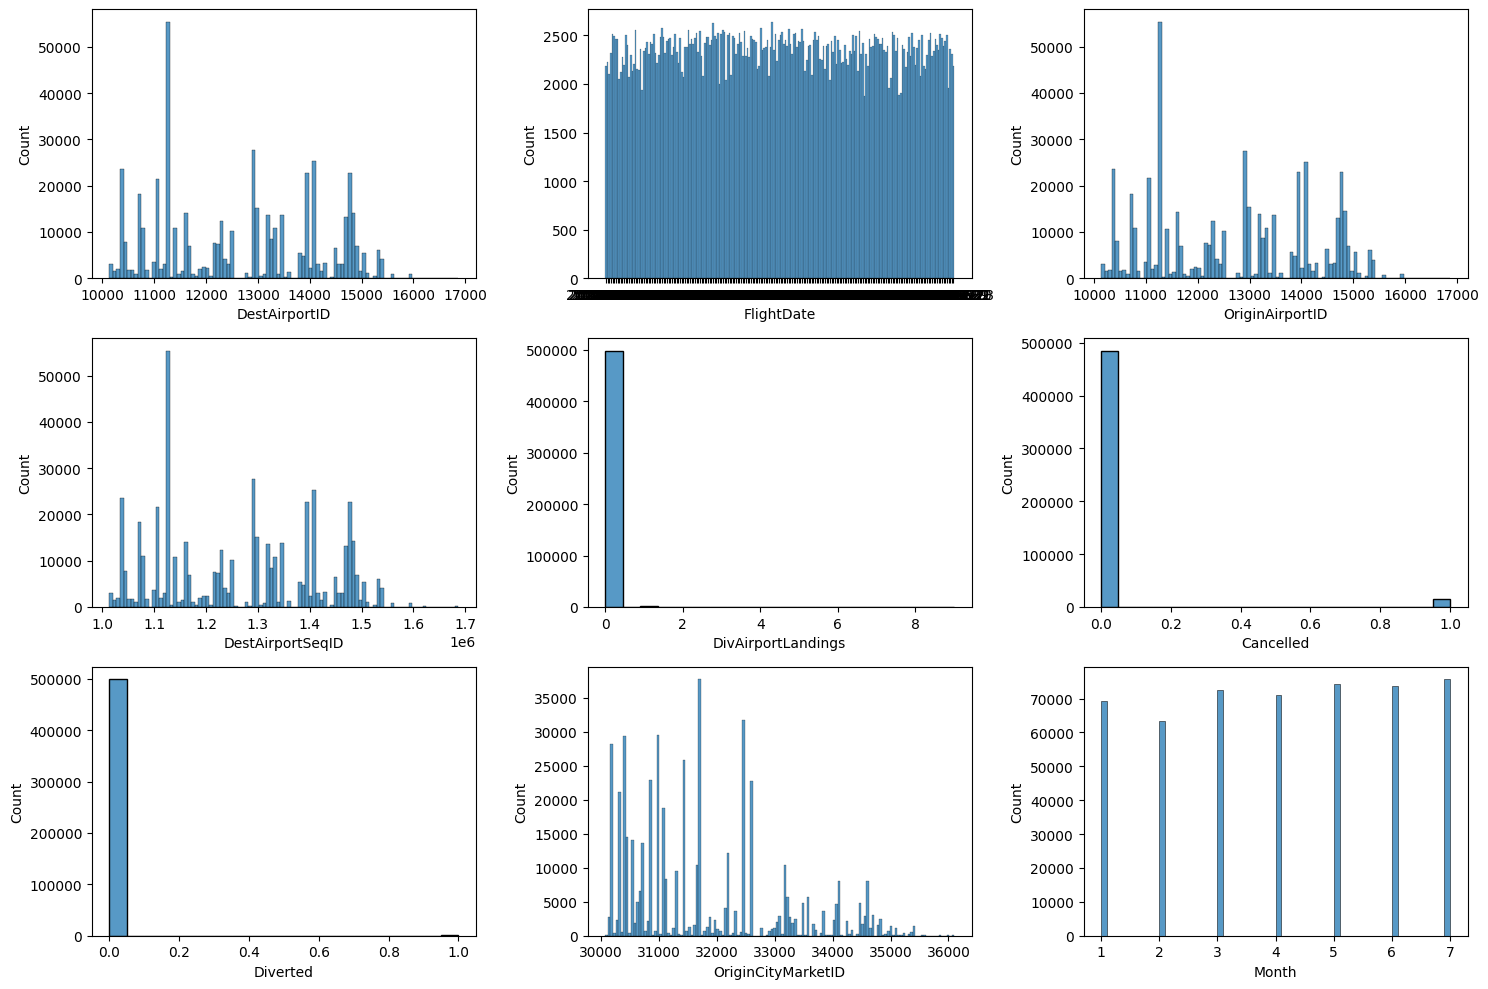

In [58]:
#Analysis on categorical values
fig, axis = plt.subplots(3, 3, figsize=(15, 10))

# Create Histogram
sns.histplot(ax = axis[0,0], data = df, x = "DestAirportID")
sns.histplot(ax = axis[0,1], data = df, x = "Airline")
sns.histplot(ax = axis[0,2], data = df, x = "OriginAirportID")
sns.histplot(ax = axis[1,0], data = df, x = "DestAirportSeqID")
sns.histplot(ax = axis[1,1], data = df, x = "DivAirportLandings")
sns.histplot(ax = axis[1,2], data = df, x = "Cancelled")
sns.histplot(ax = axis[2,0], data = df, x = "Diverted")
sns.histplot(ax = axis[2,1], data = df, x = "OriginCityMarketID")
sns.histplot(ax = axis[2,2], data = df, x = "Month")

#fig.delaxes(axis[2, 2])

plt.tight_layout()

plt.show()

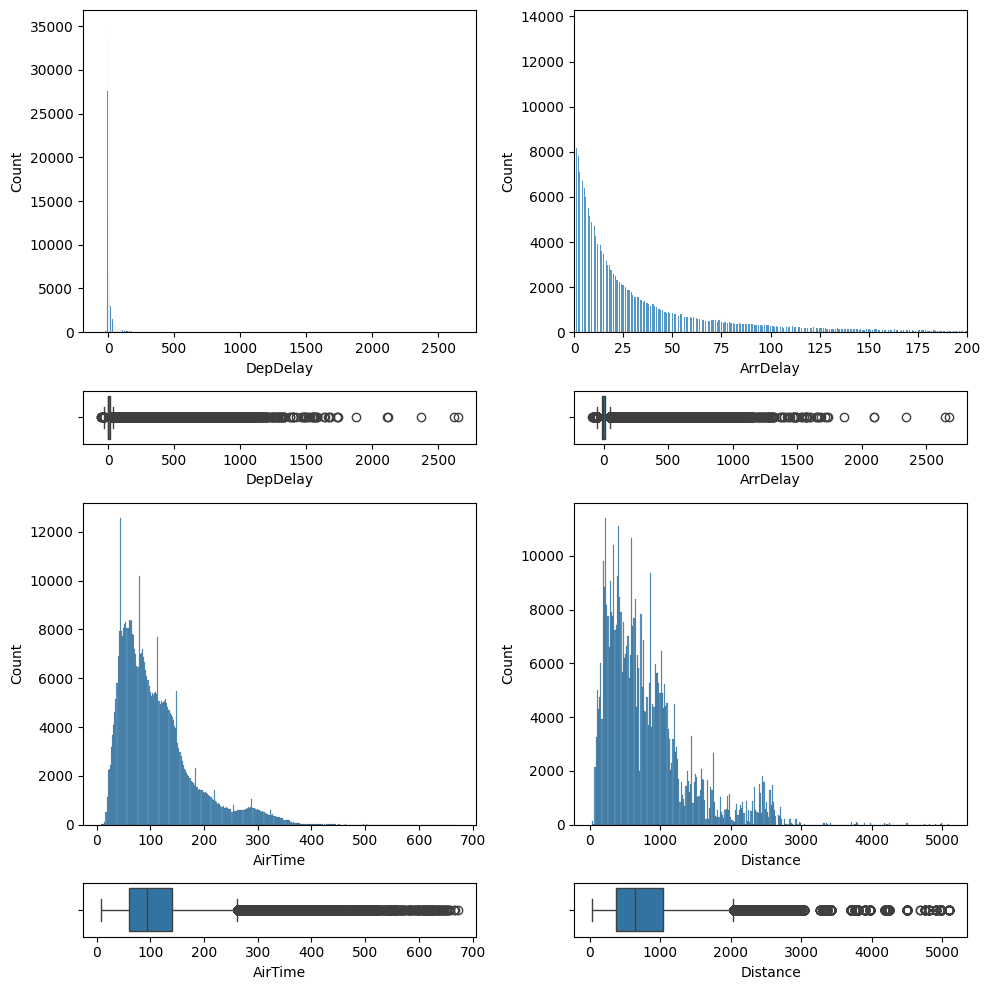

In [59]:
#Analysis on categorical values
ig, axis = plt.subplots(4, 2, figsize = (10, 10), gridspec_kw = {"height_ratios": [6, 1, 6, 1]})

sns.histplot(ax = axis[0, 0], data = df, x = "DepDelay")
sns.boxplot(ax = axis[1, 0], data = df, x = "DepDelay")

sns.histplot(ax = axis[0, 1], data = df, x = "ArrDelay").set_xlim(0, 200)
sns.boxplot(ax = axis[1, 1], data = df, x = "ArrDelay")

sns.histplot(ax = axis[2, 0], data = df, x = "AirTime")
sns.boxplot(ax = axis[3, 0], data = df, x = "AirTime")

sns.histplot(ax = axis[2,1], data = df, x = "Distance")
sns.boxplot(ax = axis[3, 1], data = df, x = "Distance")

plt.tight_layout()

plt.show()

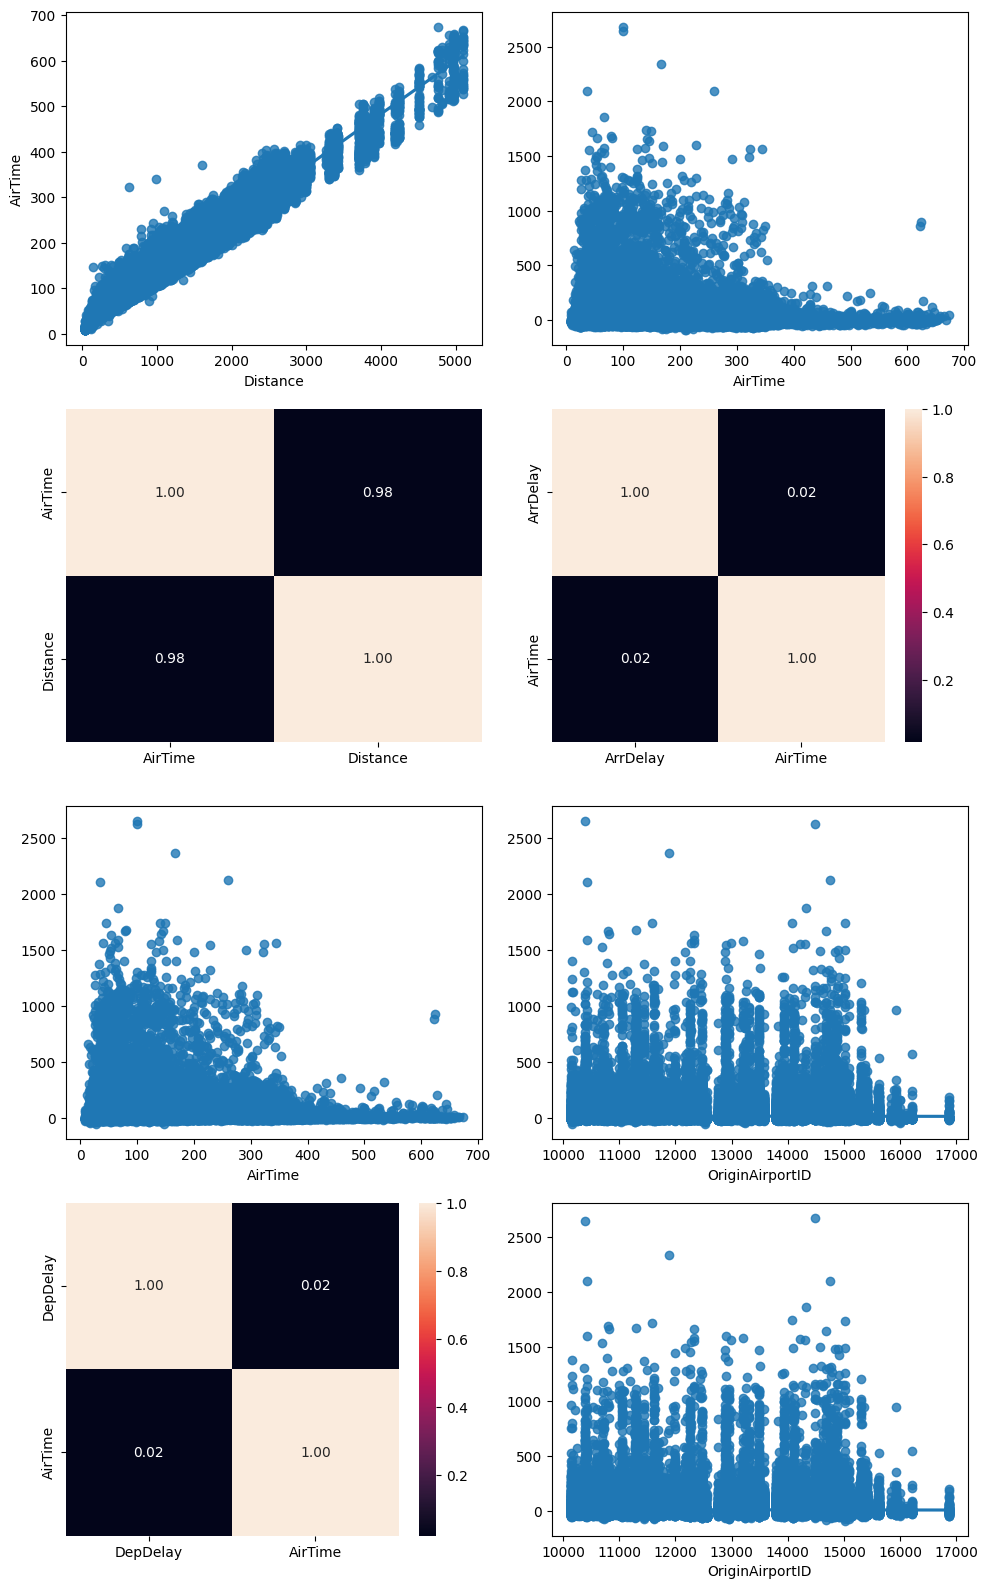

In [88]:
# Numerical - Numerical Analysis

# Create subplot canvas
fig, axis = plt.subplots(4, 2, figsize = (10, 16))

# Create Plates 
sns.regplot(ax = axis[0, 0], data = df, x = "Distance", y = "AirTime")
sns.heatmap(df[["AirTime", "Distance"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = df, x = "AirTime", y = "ArrDelay").set(ylabel = None)
sns.heatmap(df[["ArrDelay", "AirTime"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = df, x = "AirTime", y = "DepDelay").set(ylabel = None)
sns.heatmap(df[["DepDelay", "AirTime"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0]).set(ylabel = None)

sns.regplot(ax = axis[2, 1], data = df, x = "OriginAirportID", y = "DepDelay").set(ylabel = None)
sns.regplot(ax = axis[3, 1], data = df, x = "OriginAirportID", y = "ArrDelay").set(ylabel = None)

plt.tight_layout()

plt.show()

<Axes: ylabel='Frequency'>

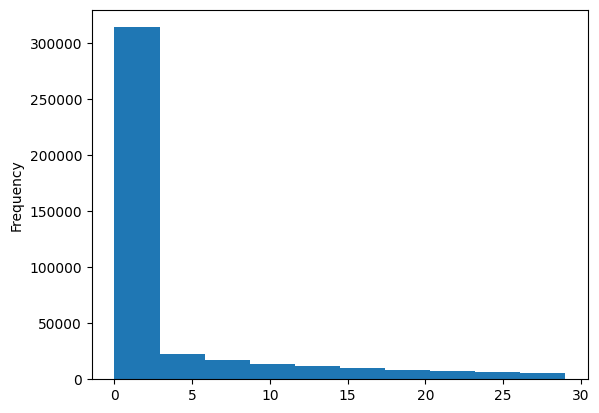

In [74]:
df.query('DepDelayMinutes < 30')['DepDelayMinutes'].plot(kind='hist')


In [38]:
filtered_df = df[df['Cancelled'] == 1]


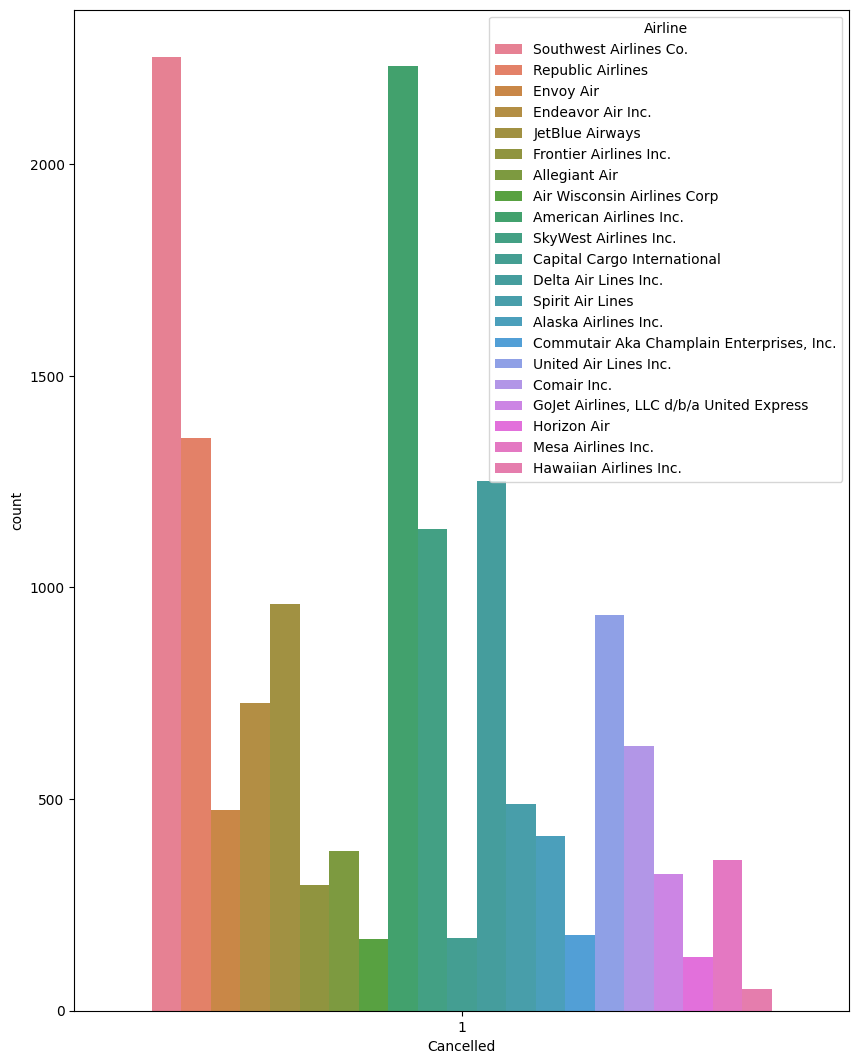

In [39]:
fig, axis = plt.subplots(figsize = (10, 13))

sns.countplot(data = filtered_df, x = "Cancelled", hue = "Airline")

plt.show()

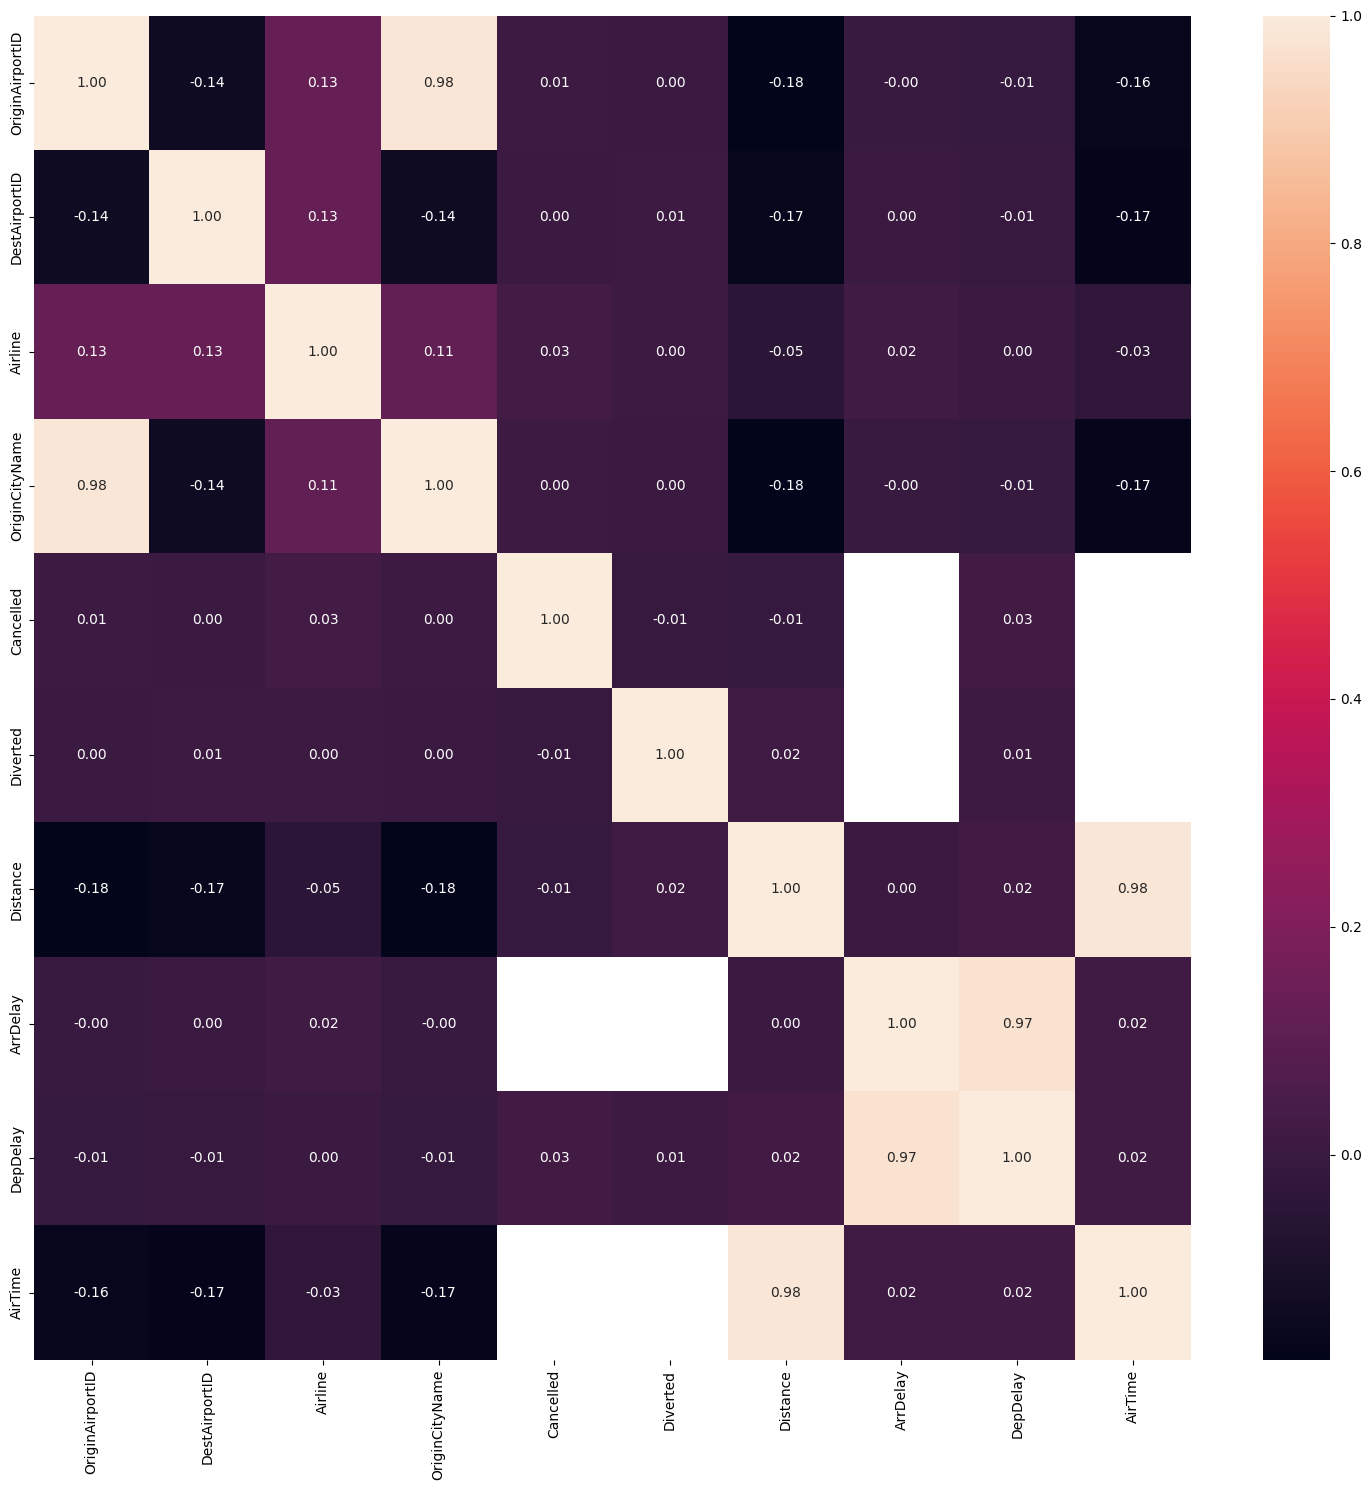

In [93]:
df["OriginAirportID"] = pd.factorize(df["OriginAirportID"])[0]
df["DestAirportID"] = pd.factorize(df["DestAirportID"])[0]
df["Airline"] = pd.factorize(df["Airline"])[0]
df["OriginCityName"] = pd.factorize(df["OriginCityName"])[0]
df["Cancelled"] = pd.factorize(df["Cancelled"])[0]
df["Diverted"] = pd.factorize(df["Diverted"])[0]

fig, axes = plt.subplots(figsize=(15, 15))

sns.heatmap(df[["OriginAirportID", "DestAirportID", "Airline", "OriginCityName", "Cancelled", "Diverted", "Distance", "ArrDelay", "DepDelay","AirTime"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

In [42]:
spearman_corr, spearman_p_value = spearmanr(df[['ArrDelay', 'AirTime']], axis=0)
print("Correlación de rango de Spearman para Variable1 y Variable3:")
print(spearman_corr)

# Calcular la correlación de rango de Kendall para las variables numéricas
kendall_corr, kendall_p_value = kendalltau(df['ArrDelay'], df['AirTime'])
print("\nCorrelación de rango de Kendall para Variable1 y Variable3:", kendall_corr)


Correlación de rango de Spearman para Variable1 y Variable3:
nan

Correlación de rango de Kendall para Variable1 y Variable3: nan


In [43]:
# Calcular la matriz de correlación de rango de Spearman
spearman_corr_matrix = df.corr(method='spearman')

print("Matriz de correlación de rango de Spearman:")
print(spearman_corr_matrix)

# Calcular la matriz de correlación de rango de Kendall
kendall_corr_matrix = df.corr(method='kendall')

print("\nMatriz de correlación de rango de Kendall:")
print(kendall_corr_matrix)


ValueError: could not convert string to float: '2022-03-19'